# Analyse des courbes d'absoption d azote des échantillons d'Alumine

In [1]:
import os
import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import math


## I/ Exploration des données

Les données sont sous la forme d'une liste de fichiers sous la forme 'no de l echantillon'.csv et d'un fichier exceel tortuosity.xls donnant le no de l'échantillon et la valeur de tortuosité

On analyse les données et on affiche les statisques sur les données de totuosité ainsi que l'histogramme

In [4]:
dataFolder='/home/irsrvshare2/R11/dgt_sandb/work/n2_tortuosity/data'

tortuosity_file=os.path.join(dataFolder,'CSV_R11','tortuosity.xls')
tortuosity_df=pd.read_excel(tortuosity_file,dtype={'ID':np.str,'TORTUOSITY':np.float})

min_tortuosity=tortuosity_df['TORTUOSITY'].min()
max_tortuosity=tortuosity_df['TORTUOSITY'].max()
mean_tortuosity=tortuosity_df['TORTUOSITY'].mean()
nb_samples = tortuosity_df.shape[0]
print("NB SAMPLES",nb_samples)
print('TORTUOSISITY MIN MAX AVG',min_tortuosity,max_tortuosity,mean_tortuosity)

NB SAMPLES 104
TORTUOSISITY MIN MAX AVG 1.6 2.7 1.988365384615384


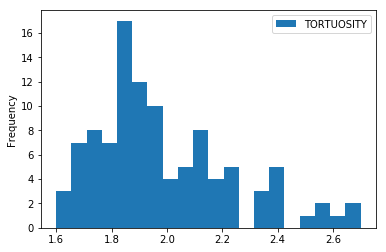

In [5]:
%matplotlib inline
tortuosity_df.plot.hist(bins=20)

### 2) définitions d'outils d'affichage ainsi que le calcul de 3 features F0, F1, F2 caractérisant l'hystéresis
Features :
- F0 : hauteur de la courbe d'hystéresis (YMAX)
- F1 : largeur de la boucle d'hystéresis (X1-X0) pour Y  > Yref
- F2 : aire de la boucle d'hystéresis

In [6]:
def eval_func(xi,yi,x,istart=0):
    #print('yi',yi)
    nx=xi.shape[0]
    x_old=0.
    y_old=0.
    if istart>0 :
        x_old=xi[istart-1]
        y_old=yi[istart-1]
    for i in range(istart,nx):
        if xi[i]>x:
            fy=y_old
            if xi[i]>x_old:
                fy = fy+(x-x_old)*(yi[i]-y_old)/(xi[i]-x_old)
            #print('FY(',i,')',x_old,x,xi[i],y_old,fy,yi[i])
            return i,fy
        else:
            x_old=xi[i]
            y_old=yi[i]
    return i,y_old

def project_func(xi,yi,x):
    nxi=xi.shape[0]
    nx=x.shape[0]
    y=np.zeros([nx],dtype=float)
    istart=0
    for i in range(nx):
        istart,y[i]=eval_func(xi,yi,x[i],istart)
        #print('     y[',i,']=',y[i])
    return y

def tortuosityBinIndex(x,xmin,xmax,nbins):
    dx=(xmax-xmin)/nbins
    return math.floor((x-xmin)/dx)
            
def normalize(df,sp):
    for i in range(sp):
        xi='x'+str(i)
        meani=df[xi].mean()
        df[xi] = df[xi].apply(lambda yi : yi - meani)
    return df
    
def computeHystFeatures(x,y,x0,eps):
    nx=x.shape[0]
    ymax = 0.
    x0eps=0.
    x1eps=0.
    ysum = 0.;
    for i in range(nx):
        ymax = max(ymax,y[i])
        if x[i]>x0:
            ysum = ysum+y[i]
            if x0eps==0:
                if y[i]>eps:
                    x0eps=x[i]
            if y[i]>eps:
                x1eps=x[i]
    return (ymax,x1eps-x0eps,ysum/nx)
 
def affiche(px,df,n,suff=""):
    sp=len(px)
    min_tortuosity=df['TORTUOSITY'].min()
    max_tortuosity=df['TORTUOSITY'].max()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    jet = plt.get_cmap('jet') 
    cNorm  = colors.Normalize(vmin=min_tortuosity, vmax=max_tortuosity)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

    lines = []
    for index,row in df.iterrows():
        if index > n:
            break
        #case=str(row[0])
        tortuosity=row[1]

        colorVal = scalarMap.to_rgba(tortuosity)
        colorText = (suff+'_df : (%4.2f)'%(tortuosity))
        retLine, = ax.plot(px,row[2:2+sp],color=colorVal,label=colorText)
        lines.append(retLine)
            
    handles,labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper left')

def afficheNP(px,df,y,nindex,suff=""):
    
    min_y=y.min()
    max_y=y.max()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    jet = cm = plt.get_cmap('jet') 
    cNorm  = colors.Normalize(vmin=min_y, vmax=max_y)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

    lines = []
    for index in range(nindex):
        tortuosity=y[index]

        colorVal = scalarMap.to_rgba(tortuosity)
        colorText = (suff+'_df : (%4.2f)'%(tortuosity))
        retLine, = ax.plot(px,df[index][:],color=colorVal,label=colorText)
        lines.append(retLine)
            
    handles,labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper left')

def afficheHyst(hyst_list,y,max_index,suff=""):
    
    min_y=y.min()
    max_y=y.max()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    jet = cm = plt.get_cmap('jet') 
    cNorm  = colors.Normalize(vmin=min_y, vmax=max_y)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

    lines = []
    index = 0
    for hyst in hyst_list:
        if index>=max_index:
            break
        tortuosity=y[index]

        colorVal = scalarMap.to_rgba(tortuosity)
        colorText = (suff+'_hyst : (%4.2f)'%(tortuosity))
        retLine, = ax.plot(hyst[0],hyst[1],color=colorVal,label=colorText)
        lines.append(retLine)
        index=index+1
            
    handles,labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper left')

def plotHystFeature(features,y,nindex):
    from mpl_toolkits.mplot3d import Axes3D
    min_y=y.min()
    max_y=y.max()
    fig = plt.figure()
    ax = fig.add_subplot(111,projection='3d')
    jet = plt.get_cmap('jet') 
    cNorm  = colors.Normalize(vmin=min_y, vmax=max_y)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    xx = []
    yy = []
    zz = []
    cc = []
    index = 0
    for feature in features:
        tortuosity=y[index]
        colorVal = scalarMap.to_rgba(tortuosity)
        xx.append(features[index][0])
        yy.append(features[index][1])
        zz.append(features[index][2])
        cc.append(colorVal)
        index=index+1
    ax.scatter(xx,yy,zz,c=cc)
    ax.set_xlabel('YMAX')
    ax.set_ylabel('DXMAX')
    ax.set_zlabel('YAVG')

In [7]:
# OUTILS POUR ECHANTILLONER LES DONNEES
nbins=10
max_binsize=50

hist_index=np.zeros(nbins+1,dtype=int)

# OUTILS POUR INTERPOLLER LES DONNES AVEC DES PAS FIXES SELON X    
sp=int(100)
px=np.zeros([sp],dtype=float)
dx=2./sp
for i in range(sp):
    px[i]=(i+1)*dx
    xi='x'+str(i)
    tortuosity_df[xi]=0.
py=np.zeros([nb_samples,sp],dtype=float)    

#OUTILS POUR DEPLIER LES COURBES D HYSTERESIS
hsp = int(sp/2)        
hyst_px=np.zeros([hsp],dtype=float)
for i in range(hsp):
    hyst_px[i]=(i+1)*dx    
hyst_py=np.zeros([nb_samples,hsp],dtype=float)    

row_indexes = []
row_ids = []
rindex = 0

hyst_curves = []
hyst_features = []
for index,row in tortuosity_df.iterrows():
    #if index>0:
    #    break
    case=str(row[0])
    tortuosity=row[1]

    bin_index = tortuosityBinIndex(tortuosity,min_tortuosity,max_tortuosity,nbins)
    if hist_index[bin_index] < max_binsize:
        print(index,'name',case,' TORTUOSITY ',tortuosity)
            
        hist_index[bin_index] = hist_index[bin_index] + 1
        row_indexes.append(index)
        row_ids.append(case)
        file=os.path.join(dataFolder,'CSV_R11',case+'.xls')
        df=pd.read_excel(file)
        def fx(x,x_old,hysteresis):
            if x<x_old:
                hysteresis=True
            if hysteresis:
                return True,2.-x
            else:
                return False,x
    
        hysteresis=False 
        x_old=0.
        hys_x = []
        hys_y = []
        nx=df.shape[0]
        hyst_x0 = max(df['pression_relative'][0],df['pression_relative'][nx-1])
        for i,df_row in df.iterrows():
            if df_row[0]>=hyst_x0:
                hys_x.append(df_row[0])
                hys_y.append(df_row[1])
            hysteresis,x=fx(df_row[0],x_old,hysteresis)
            #print("HYST",hysteresis,x,x_old,df_row[0],df_row[1])
            x_old=df_row[0]
            df['pression_relative'][i]=x
        hyst_curves.append((hys_x,hys_y))
        x=df['pression_relative']
        y=df['volume']
            
                
        ppy=project_func(x,y,px)
        py[rindex] = ppy
        rindex = rindex+1
        for j in range(sp):
            tortuosity_df.iloc[index,2+j] = ppy[j]

        for j in range(hsp):
            hyst_py[index][j] = ppy[2*hsp-2-j]-ppy[j]
            #print('PH',j,px[j],px[2*hsp-2-j], 'DY',ppy[2*hsp-2-j]-ppy[j],'Y',ppy[j],ppy[2*hsp-2-j])
        hyst_features.append(computeHystFeatures(hyst_px,hyst_py[index],0.4,25.))

print("NB SMPLES",rindex,len(row_indexes))

0 name 135173  TORTUOSITY  1.99
1 name 152093  TORTUOSITY  2.24
2 name 152274  TORTUOSITY  1.78
3 name 152697  TORTUOSITY  2.32
4 name 153628  TORTUOSITY  1.66
5 name 155470  TORTUOSITY  2.08
6 name 156717  TORTUOSITY  1.81
7 name 157303  TORTUOSITY  2.7
8 name 158245  TORTUOSITY  2.06
9 name 159509  TORTUOSITY  1.76
10 name 163849  TORTUOSITY  2.61
11 name 164023  TORTUOSITY  1.72
12 name 164123  TORTUOSITY  1.89
13 name 166667  TORTUOSITY  1.76
14 name 166671  TORTUOSITY  1.78
15 name 166931  TORTUOSITY  2.32
16 name 167252  TORTUOSITY  1.65
17 name 167254  TORTUOSITY  1.71
18 name 167477  TORTUOSITY  1.87
19 name 167479  TORTUOSITY  1.79
20 name 167589  TORTUOSITY  1.76
21 name 167900  TORTUOSITY  2.19
22 name 167901  TORTUOSITY  2.39
23 name 167902  TORTUOSITY  2.23
24 name 167903  TORTUOSITY  2.04
25 name 167904  TORTUOSITY  1.6
26 name 167905  TORTUOSITY  1.7
27 name 167906  TORTUOSITY  1.86
28 name 168125  TORTUOSITY  1.72
29 name 170535  TORTUOSITY  1.95
30 name 170734  TORTUOS

### 3) Affichage de quelques courbes d'hystérésis

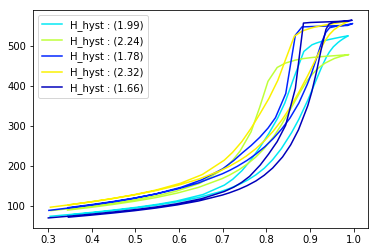

In [6]:
# AFFICHAGE des Hysteresis
afficheHyst(hyst_curves,tortuosity_df['TORTUOSITY'].values,5,"H")

### 4) Affichage des courbes dépliées

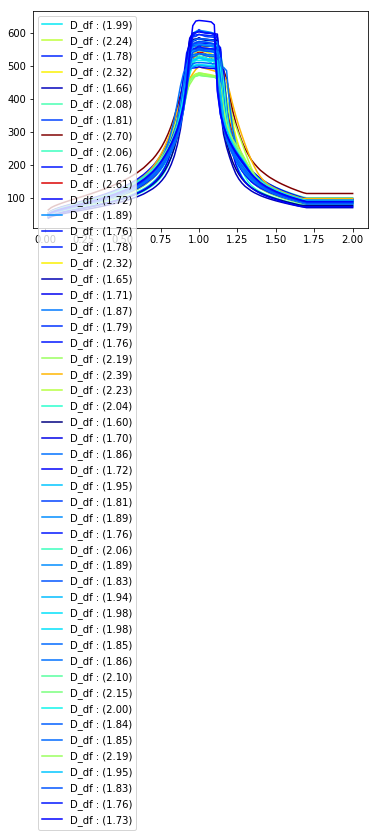

In [8]:
# AFFICHAGE DES COURBES DEPLIEES
affiche(px,tortuosity_df,50,'D')

### 5) Affichage de la coubes d'Hysteresis H(x) = F(x+) - F(x-)

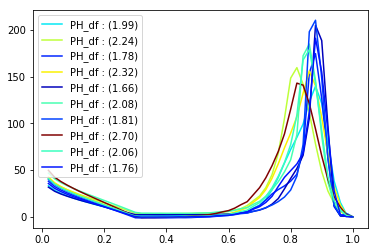

In [9]:
# AFFICHAGE DES COURBES D HYSTERESIS PROJETE
afficheNP(hyst_px,hyst_py,tortuosity_df['TORTUOSITY'].values,10,"PH")

### 6) Affichage dans l'espace des features (F0,F1,F2)

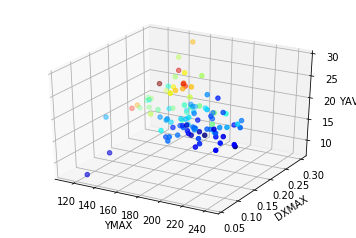

In [9]:
# AFFICHAGE DES FEATURES (YMAX,DXMAX,YAVG)
plotHystFeature(hyst_features,tortuosity_df['TORTUOSITY'].values,100)

### 7) Normalisation des données et affichage des courbes normalisées

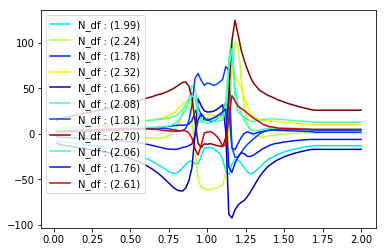

In [10]:
# NORMALISATION
normalize(tortuosity_df,sp)
affiche(px,tortuosity_df,10,"N")

### 8) Réduction de dimension par PCA

In [11]:
# REDUCTION MODELE PAR PCA
def computePCA(X,ncomp):
    import numpy as np
    from sklearn.decomposition import PCA
    pca = PCA(n_components=ncomp)
    new_x=pca.fit_transform(X)  
    print(pca.explained_variance_ratio_)  
    print(pca.singular_values_)
    return new_x,pca

[0.50306839 0.36794778 0.07106419 0.02750449 0.01159041 0.00640675
 0.00449279 0.00317211 0.00174491 0.00078901]
[1975.59899099 1689.57849325  742.52429673  461.94159653  299.87118343
  222.94825293  186.69950638  156.87698065  116.35148969   78.23970701]


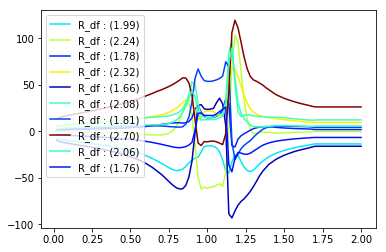

In [12]:
# REDUCTION DE DIMENSION PAR PCA, AFFICHAGE DU MODELE REDUIT
X=tortuosity_df.iloc[:,2:2+sp]
y=tortuosity_df['TORTUOSITY'].values

reducted_X,pca=computePCA(X.values,10)
new_X=pca.inverse_transform(reducted_X)
afficheNP(px,new_X,y,10,"R")

In [13]:
def afficheBase(px,base_x):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    lines = []
    retLine, = ax.plot(px,base_x[0][:],color='red',label='base0')
    lines.append(retLine)
    retLine, = ax.plot(px,base_x[1][:],color='blue',label='base1')
    lines.append(retLine)
    retLine, = ax.plot(px,base_x[2][:],color='green',label='base2')
    lines.append(retLine)            
    handles,labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper left')

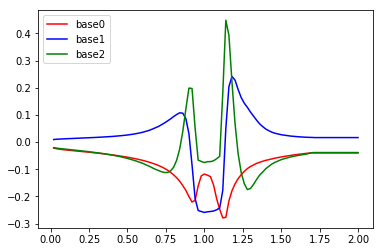

In [14]:
# Affichage des 3 premieres base
base_X=np.zeros([3,10],dtype=float)
base_X[0][0] = 1.
base_X[1][1] = 1.
base_X[2][2] = 1.

new_base_X=pca.inverse_transform(base_X)
afficheBase(px,new_base_X)

## II/ Analyse du recouvrement de l'échantillonage

In [15]:
def plotTrainTestCover(reducted_x_train,reducted_x_test):
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111,projection='3d')
    xx = []
    yy = []
    zz = []
    cc = []
    for x in reducted_x_train:
        xx.append(x[0])
        yy.append(x[1])
        zz.append(x[2])
        cc.append('blue')
    for x in reducted_x_test:
        xx.append(x[0])
        yy.append(x[1])
        zz.append(x[2])
        cc.append('red')
        
    ax.scatter(xx,yy,zz,c=cc)
    ax.set_xlabel('C0')
    ax.set_ylabel('C1')
    ax.set_zlabel('C2')

### 1) Affichage dans l'espace des 3 premières composantes de PCA

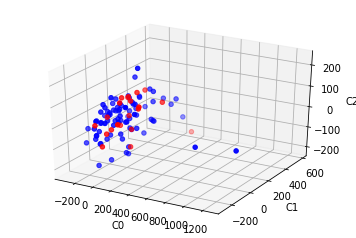

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reducted_X, y, test_size=0.2, random_state=42) 
plotTrainTestCover(X_train,X_test)

### 2) Affichage dans l'espace des features F0, F1 et F2

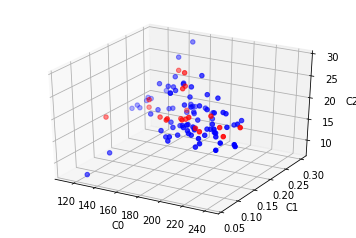

In [17]:
features_X=np.zeros([y.shape[0],3],dtype=float)
index=0
for feature in hyst_features:
        features_X[index][0]=feature[0]
        features_X[index][1]=feature[1]
        features_X[index][2]=feature[2]
        index=index+1
        
X_train, X_test, y_train, y_test = train_test_split(features_X, y, test_size=0.2, random_state=42)  
plotTrainTestCover(X_train,X_test)

## III/ Benchmark de différents algorithmes de regression

In [22]:
# CALCUL DE PREDICTION A L AIDE D'ALGO DE REGRESSION
def compute_predict(clf,name,X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    yy=clf.predict(X_test)

    score = clf.score(X_test, y_test)
    print("R2 SCORE",name,score)
    yy_err = np.zeros([yy.shape[0]],dtype=float)
    for i in range(yy.shape[0]):
        yy_err[i] = abs(yy[i]-y_test[i])*2/(yy[i]+y_test[i])
    return yy,yy_err

In [23]:
def plotRegressionModelResults(model_name,y_test,y_pred,y_err):
    fig = plt.figure()
    plt.subplot(121)
    plt.hist(y_err,bins=20)
    plt.title('Histogram Err'+model_name)
    plt.subplot(122)
    plt.scatter(y_test,y_pred,color='red')
    plt.scatter(y_test,y_test,color='blue')
    plt.show()

In [24]:
# TEST DE DIFFERENTS ALGOS DE REGRESSION
from sklearn.model_selection import train_test_split

    
from sklearn.svm import SVR
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.linear_model.ridge import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
#from sklearn.linear_model.stochastic_gradient import SGDRegressor
#(SVR(gamma='scale', C=1.0, epsilon=0.2),"SVR2"),
models = [(SVR(kernel='linear',degree=3),"SVR"),
          (RandomForestRegressor(max_depth=4, random_state=0,n_estimators=250),"RFR"),
          (Ridge(alpha=1.0),"RIDGE"),
          (Lasso(alpha=0.1),"LASSO"),
          (ElasticNet(alpha=1.0),"ElasiticNet")]
#clf_sgd = SGDRegressor(max_iter=5)

### 1) Test sans réduction de dimension

R2 SCORE SVR -0.24873413451349882


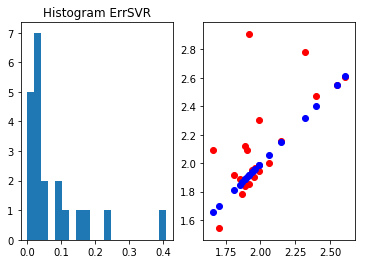

R2 SCORE RFR 0.31021470540692164


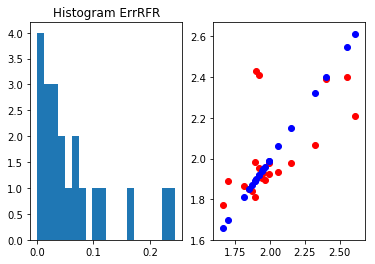

R2 SCORE RIDGE 0.09543581397287326


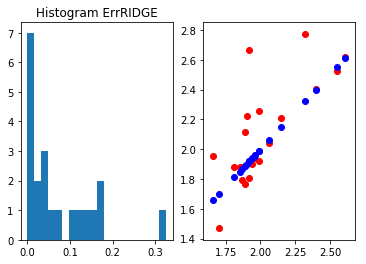

/work/irlin355_1/gratienj/BigData/local/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


R2 SCORE LASSO 0.5633886076568844


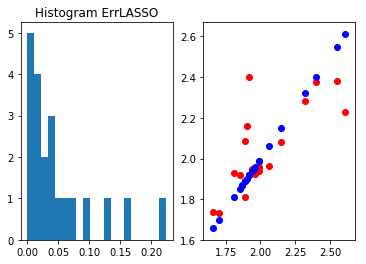

R2 SCORE ElasiticNet 0.3153022225083535


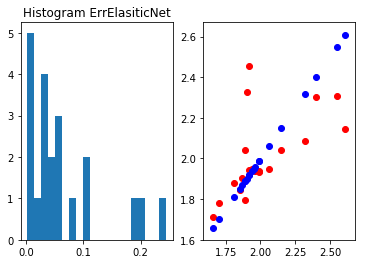

In [25]:
# TEST SANS REDUCTION DE DIMENSION
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  
for model in models:
    yy,err = compute_predict(model[0],model[1],X_train, X_test, y_train, y_test)
    plotRegressionModelResults(model[1],y_test,yy,err)


### 2) Tests avec reduction de dimensions

R2 SCORE SVR 0.6167696139249339


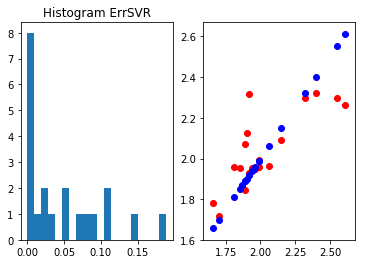

R2 SCORE RFR 0.42975522968172214


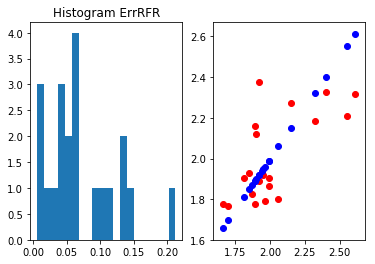

R2 SCORE RIDGE 0.6276213869633783


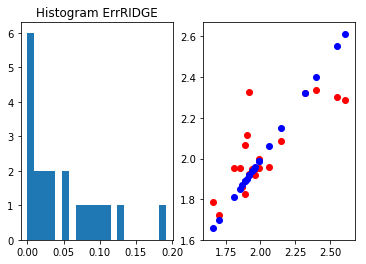

R2 SCORE LASSO 0.6002919877614936


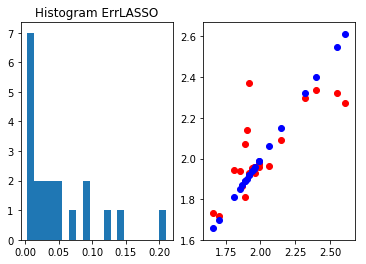

R2 SCORE ElasiticNet 0.39358626795378376


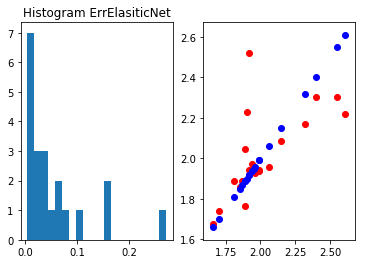

In [26]:
# TESTS AVEC REDUCTION DE DIMESNION

X_train, X_test, y_train, y_test = train_test_split(reducted_X, y, test_size=0.2, random_state=42)    
results={}
for model in models:
    yy,err = compute_predict(model[0],model[1],X_train, X_test, y_train, y_test)
    plotRegressionModelResults(model[1],y_test,yy,err)

### 3) Test de prédiction en utilisant que les 3 Features F0,F1, F2

R2 SCORE SVR 0.6980710839979226


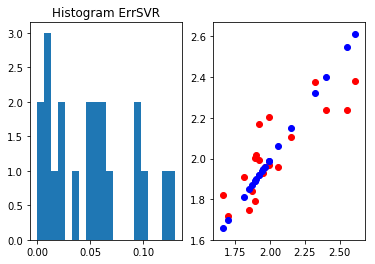

R2 SCORE RFR 0.6030072482635227


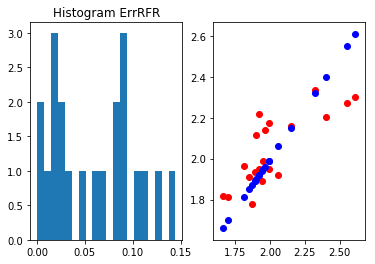

R2 SCORE RIDGE 0.68101943644277


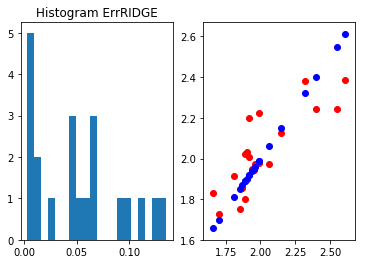

R2 SCORE LASSO 0.6093407252913258


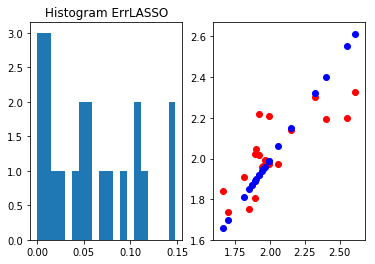

R2 SCORE ElasiticNet 0.1910526720774255


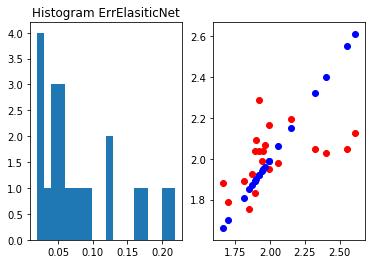

In [27]:
features_X=np.zeros([y.shape[0],3],dtype=float)
index=0
for feature in hyst_features:
        features_X[index][0]=feature[0]
        features_X[index][1]=feature[1]
        features_X[index][2]=feature[2]
        index=index+1
        
X_train, X_test, y_train, y_test = train_test_split(features_X, y, test_size=0.2, random_state=42)    

    
for model in models:
    yy,err = compute_predict(model[0],model[1],X_train, X_test, y_train, y_test)
    plotRegressionModelResults(model[1],y_test,yy,err)


### 4) Tests PCA + features F0, F1, F2

R2 SCORE SVR 0.5897742784343363


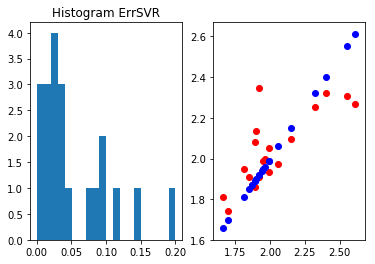

R2 SCORE RFR 0.6109098774042087


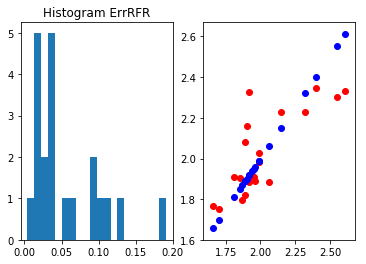

R2 SCORE RIDGE 0.6229640912388019


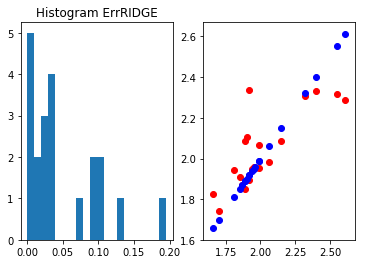

R2 SCORE LASSO 0.6489815977910258


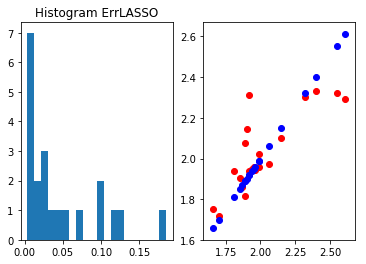

R2 SCORE ElasiticNet 0.39358626795378376


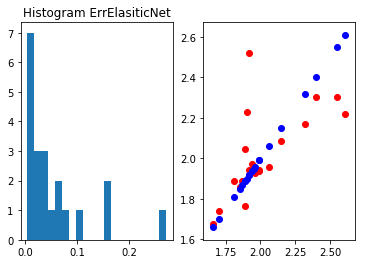

In [28]:
reducted_nc=reducted_X.shape[1]
reducted_features_X=np.zeros([y.shape[0],reducted_nc+3],dtype=float)
index=0
for feature in hyst_features:
    for j in range(reducted_nc):
        reducted_features_X[index][j] = reducted_X[index][j]
    reducted_features_X[index][reducted_nc]  =feature[0]
    reducted_features_X[index][reducted_nc+1]=feature[1]
    reducted_features_X[index][reducted_nc+2]=feature[2]
    index=index+1
        
X_train, X_test, y_train, y_test = train_test_split(reducted_features_X, y, test_size=0.2, random_state=42)    

    
for model in models:
    yy,err = compute_predict(model[0],model[1],X_train, X_test, y_train, y_test)
    plotRegressionModelResults(model[1],y_test,yy,err)

## IV/ Prédiction avec XGBoost

In [29]:
import xgboost as xgb

In [30]:

def GridSearchOptim(params, gridsearch_params, xgtrain, num_boost_round, nfold, metric, early_stopping, ParName, min_mae):
    
#    min_mae = float("Inf")    
    
    nbParam = len(np.shape([gridsearch_params])) - 1
    
    if nbParam == 2:
        best_params = (params[ParName[0]],params[ParName[1]])
        for param1, param2 in gridsearch_params:       
            # Update our parameters
            params[ParName[0]] = param1
            params[ParName[1]] = param2
            # Run CV
            cv_results = xgb.cv(params, xgtrain, num_boost_round=num_boost_round, nfold=nfold, \
                                metrics={metric}, early_stopping_rounds=early_stopping )
            # Update best MAE
            mean_mae = cv_results['test-' + metric + '-mean'].min()
            if mean_mae < min_mae:
                min_mae = mean_mae
                best_params = (param1,param2)
        
        params[ParName[0]] = best_params[0]
        params[ParName[1]] = best_params[1]
    else:
        best_params = (params[ParName])
        for par in gridsearch_params :
            params[ParName] = par    
            # Run CV
            cv_results = xgb.cv(params,xgtrain,num_boost_round=num_boost_round, nfold=nfold,\
                                metrics={metric},early_stopping_rounds=early_stopping)
            # Update best score
            mean_mae = cv_results['test-' + metric + '-mean'].min()
            if mean_mae < min_mae:
                min_mae = mean_mae
                best_params = par
                
        params[ParName] = best_params

    return params, min_mae


def OptimizeParams(Init_Params, nfold, early_stopping, num_boost_round, metric, LearningData, LearningTarget):
    
    xgb_model = xgb.XGBRegressor(learning_rate = np.array( Init_Params['learning_rate'], dtype=float),\
                                 n_estimators = np.array( Init_Params['n_estimators'], dtype=int),\
                                 max_depth = np.array(Init_Params['max_depth'], dtype=int),\
                                 
                                 min_child_weight = np.array( Init_Params['min_child_weight'], dtype=int),\
                                 gamma = np.array( Init_Params['gamma'], dtype=float),\
                                 subsample = np.array( Init_Params['subsample'], dtype=float),\
                                 colsample_bytree = np.array( Init_Params['colsample_bytree'], dtype=float),\
                                 scale_pos_weight = np.array(Init_Params['scale_pos_weight'], dtype=float),\
                                 
                                 reg_lambda = np.array( Init_Params['reg_lambda'], dtype=float), \
                                 reg_alpha = np.array( Init_Params['reg_alpha'], dtype=float), \
                                 seed = np.array( 42, dtype=int) , \
                                 nthread  = np.array(4, dtype=int))
    
    xgtrain = xgb.DMatrix(LearningData, LearningTarget)
        
    ###############################################################################
                    ## Optimisation de 'n_estimators' ##
    ###############################################################################
    params = xgb_model.get_params();

    cvresult = xgb.cv(params, xgtrain, num_boost_round=num_boost_round, nfold=nfold, \
                      metrics=metric, early_stopping_rounds=early_stopping)
        
    min_mae = cvresult['test-'  + metric + '-mean'].min()
    params['n_estimators'] = cvresult['test-'  + metric + '-mean'].idxmin()
    print("Best params for 'n_estimators': {} ---> Error : {}".format(params['n_estimators'], min_mae))
        
      
    ###############################################################################
        ## Optimisation des parametres 'max_depth' et 'min_child_weight' ##

    ###############################################################################
    ParName = ['max_depth', 'min_child_weight']

    gridsearch_params = [(max_depth, min_child_weight) for max_depth in range(2,11) for min_child_weight in range(1,7)]    
    params, min_mae = GridSearchOptim(params, gridsearch_params, xgtrain, num_boost_round, nfold, metric, early_stopping, ParName, min_mae)

    print("Best params for 'max_depth': {} and 'min_child_weight': {} ---> Error : {}".format(params[ParName[0]], params[ParName[1]], min_mae))
    
    ###############################################################################
        ## Optimisation des parametres 'subsample' et 'colsample' ##
    ###############################################################################
    ParName = ['subsample', 'colsample_bytree']

    gridsearch_params = [(subsample, colsample) for subsample in [i/10. for i in range(5,11)] for colsample in [i/10. for i in range(5,11)]]
    params, min_mae = GridSearchOptim(params, gridsearch_params, xgtrain, num_boost_round, nfold, metric, early_stopping, ParName, min_mae)

    print("Best params for 'subsample': {} and 'colsample_bytree': {} ---> Error : {}".format(params[ParName[0]], params[ParName[1]], min_mae))
        
    
    ###############################################################################
                    ## Optimisation du parametre 'gamma' ##
    ###############################################################################
    ParName = 'gamma'
    
    gridsearch_params = [i/10. for i in range(0,11)]
    params, min_mae = GridSearchOptim(params, gridsearch_params, xgtrain, num_boost_round, nfold, metric, early_stopping, ParName, min_mae)

    print("Best params for 'gamma': {} ---> Error : {}".format(params[ParName], min_mae))
        
    ###############################################################################
        ## Optimisation du parametre 'reg_lambda' et 'reg_alpha' ##
    ###############################################################################

    ParName = ['reg_lambda', 'reg_alpha']

    gridsearch_params = [(reg_lambda, reg_alpha) for reg_lambda in [i/10. for i in range(0,11)] for reg_alpha in [i/10. for i in range(0,11)]]
    params, min_mae = GridSearchOptim(params, gridsearch_params, xgtrain, num_boost_round, nfold, metric, early_stopping, ParName, min_mae)

    print("Best params for 'reg_lambda': {} and 'reg_alpha': {} ---> Error : {}".format(params[ParName[0]], params[ParName[1]], min_mae))
 
    
    ###############################################################################
                ## Optimisation du parametre 'learning_rate' ##
    ###############################################################################
    
    ParName = 'learning_rate'
    
    gridsearch_params = [.3, .2, .1, .05, .04, .03, .02, .01, .005]
    params, min_mae = GridSearchOptim(params, gridsearch_params, xgtrain, num_boost_round, nfold, metric, early_stopping, ParName, min_mae)

    print("Best params for 'learning_rate': {} ---> Error : {}".format(params[ParName], min_mae))
 

    return params

In [31]:
def computeXGBParam(LearningData, LearningTarget):
    Init_Params = {
        'learning_rate' : 0.1,
        'n_estimators' : 500,
        'max_depth': 5,
        'min_child_weight' : 1,
        'gamma' : 0,
        'subsample' : 0.8,
        'colsample_bytree' : 0.8,
        'scale_pos_weight' : 1,
        'reg_lambda' : 1,
        'reg_alpha' : 0,
        "booster":"gbtree"
        }


    params = {}
    Eta_n0 = Init_Params['learning_rate']
    Eta_n1 = 0
 
    metric = 'mae'

    nfold = 10
    early_stopping = 10
    num_boost_round = 1000
   
    while Eta_n0 != Eta_n1:
        Eta_n0 = Init_Params['learning_rate']
        params = OptimizeParams(Init_Params, nfold, early_stopping, num_boost_round, metric, LearningData, LearningTarget)
        Eta_n1 = params['learning_rate']
        Init_Params = params
    return params

In [38]:
def compute_xgb_predict(model_name,xgb_params,X_train, X_test, y_train, y_test):
    model = xgb.XGBRegressor(\
          learning_rate    = np.array( xgb_params['learning_rate'], dtype=float), \
          n_estimators     = np.array( xgb_params['n_estimators'], dtype=int),\
          max_depth        = np.array( xgb_params['max_depth'], dtype=int),\
          min_child_weight = np.array( xgb_params['min_child_weight'], dtype=int),\
          gamma            = np.array( xgb_params['gamma'], dtype=float),\
          subsample        = np.array( xgb_params['subsample'], dtype=float),\
          colsample_bytree = np.array( xgb_params['colsample_bytree'], dtype=float),\
          reg_lambda       = np.array( xgb_params['reg_lambda'], dtype=float), \
          reg_alpha        = np.array( xgb_params['reg_alpha'], dtype=float), \
          seed             = np.array( 42, dtype=int) , \
          nthread          = np.array(4, dtype=int))
 
    metric = 'mae'

    Model = model.fit(X_train, y_train,eval_metric=metric)
    yy=Model.predict(X_test)

    score = Model.score(X_test, y_test)
    print("R2 SCORE",model_name,score)
    xgb.plot_importance(model)
    yy_err = np.zeros([yy.shape[0]],dtype=float)
    for i in range(yy.shape[0]):
        yy_err[i] = abs(yy[i]-y_test[i])*2/(yy[i]+y_test[i])
    return yy,yy_err

### 1) XGBoost raw data

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  

Best params for 'n_estimators': 50 ---> Error : 0.12439679999999997
Best params for 'max_depth': 7 and 'min_child_weight': 3 ---> Error : 0.1183379
Best params for 'subsample': 0.6 and 'colsample_bytree': 0.9 ---> Error : 0.1124979
Best params for 'gamma': 0.0 ---> Error : 0.1124979
Best params for 'reg_lambda': 1.0 and 'reg_alpha': 0.0 ---> Error : 0.1124979
Best params for 'learning_rate': 0.1 ---> Error : 0.1124979
R2 SCORE XGBoost-RawData 0.372304689615662


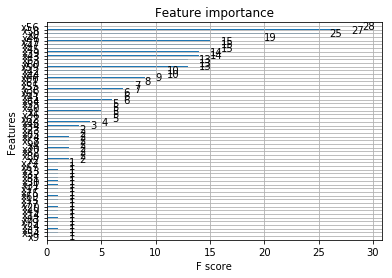

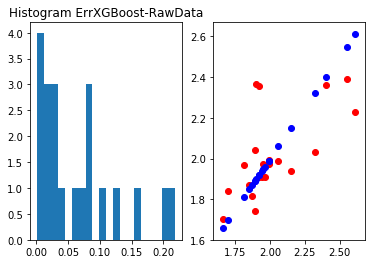

In [40]:
params = computeXGBParam(X_train,y_train)
yy_pred,yy_err = compute_xgb_predict("XGBoost-RawData",params,X_train, X_test, y_train, y_test)
plotRegressionModelResults("XGBoost-RawData",y_test,yy_pred,yy_err) 

### 2) PCA reducted data 

In [41]:
X_train, X_test, y_train, y_test = train_test_split(reducted_X, y, test_size=0.2, random_state=42) 

Best params for 'n_estimators': 59 ---> Error : 0.109223
Best params for 'max_depth': 4 and 'min_child_weight': 3 ---> Error : 0.10571540000000001
Best params for 'subsample': 0.5 and 'colsample_bytree': 0.9 ---> Error : 0.10461430000000001
Best params for 'gamma': 0.0 ---> Error : 0.10461430000000001
Best params for 'reg_lambda': 1.0 and 'reg_alpha': 0.1 ---> Error : 0.10203630000000001
Best params for 'learning_rate': 0.1 ---> Error : 0.10203630000000001
R2 SCORE XGBoost-RedData 0.7095874955002088


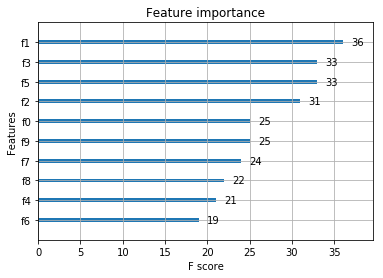

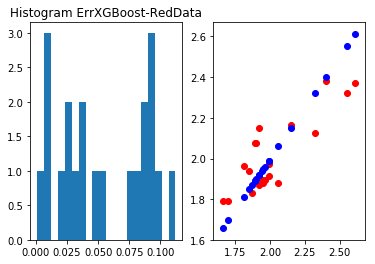

In [42]:
params = computeXGBParam(X_train,y_train)
yy_pred,yy_err = compute_xgb_predict("XGBoost-RedData",params,X_train, X_test, y_train, y_test)
plotRegressionModelResults("XGBoost-RedData",y_test,yy_pred,yy_err) 

### 3) Feature Data

In [43]:
features_X=np.zeros([y.shape[0],3],dtype=float)
index=0
for feature in hyst_features:
        features_X[index][0]=feature[0]
        features_X[index][1]=feature[1]
        features_X[index][2]=feature[2]
        index=index+1
        
X_train, X_test, y_train, y_test = train_test_split(features_X, y, test_size=0.2, random_state=42)    

Best params for 'n_estimators': 67 ---> Error : 0.10586290000000001
Best params for 'max_depth': 9 and 'min_child_weight': 2 ---> Error : 0.1037223
Best params for 'subsample': 1.0 and 'colsample_bytree': 1.0 ---> Error : 0.10157179999999999
Best params for 'gamma': 0.0 ---> Error : 0.10157179999999999
Best params for 'reg_lambda': 0.1 and 'reg_alpha': 0.1 ---> Error : 0.0992764
Best params for 'learning_rate': 0.01 ---> Error : 0.09916149999999999
Best params for 'n_estimators': 469 ---> Error : 0.09916149999999999
Best params for 'max_depth': 2 and 'min_child_weight': 2 ---> Error : 0.0988871
Best params for 'subsample': 1.0 and 'colsample_bytree': 1.0 ---> Error : 0.0988871
Best params for 'gamma': 0.0 ---> Error : 0.0988871
Best params for 'reg_lambda': 0.1 and 'reg_alpha': 0.1 ---> Error : 0.0988871
Best params for 'learning_rate': 0.03 ---> Error : 0.0985149
Best params for 'n_estimators': 252 ---> Error : 0.0985149
Best params for 'max_depth': 2 and 'min_child_weight': 2 ---> Er

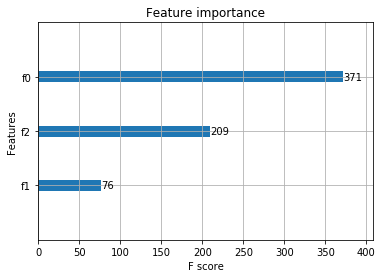

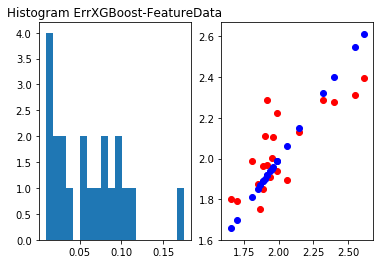

In [44]:
params = computeXGBParam(X_train,y_train)
yy_pred,yy_err = compute_xgb_predict("XGBoost-FeatureData",params,X_train, X_test, y_train, y_test)
plotRegressionModelResults("XGBoost-FeatureData",y_test,yy_pred,yy_err) 

### 4) PCA reductured + Feature Data

In [45]:
reducted_nc=reducted_X.shape[1]
reducted_features_X=np.zeros([y.shape[0],reducted_nc+3],dtype=float)
index=0
for feature in hyst_features:
    for j in range(reducted_nc):
        reducted_features_X[index][j] = reducted_X[index][j]
    reducted_features_X[index][reducted_nc]  =feature[0]
    reducted_features_X[index][reducted_nc+1]=feature[1]
    reducted_features_X[index][reducted_nc+2]=feature[2]
    index=index+1
        
X_train, X_test, y_train, y_test = train_test_split(reducted_features_X, y, test_size=0.2, random_state=42)    

Best params for 'n_estimators': 52 ---> Error : 0.0953861
Best params for 'max_depth': 4 and 'min_child_weight': 1 ---> Error : 0.09130529999999999
Best params for 'subsample': 0.8 and 'colsample_bytree': 0.6 ---> Error : 0.0876381
Best params for 'gamma': 0.0 ---> Error : 0.0876381
Best params for 'reg_lambda': 0.0 and 'reg_alpha': 0.1 ---> Error : 0.08585559999999999
Best params for 'learning_rate': 0.1 ---> Error : 0.08585559999999999
R2 SCORE XGBoost-RedFeatureData 0.7756818338095912


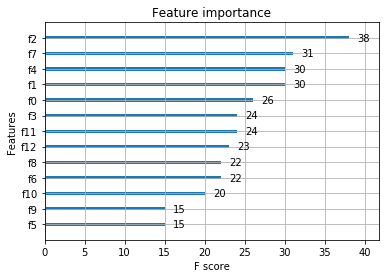

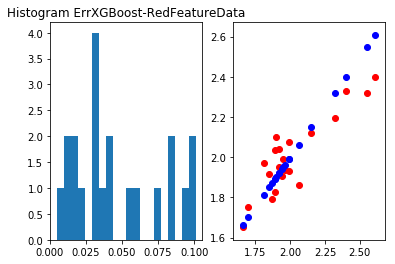

In [47]:
params = computeXGBParam(X_train,y_train)
yy_pred,yy_err = compute_xgb_predict("XGBoost-RedFeatureData",params,X_train, X_test, y_train, y_test)
plotRegressionModelResults("XGBoost-RedFeatureData",y_test,yy_pred,yy_err) 